In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from itertools import combinations
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import mode
from sklearn.metrics import (
    adjusted_mutual_info_score,
    adjusted_rand_score,
)
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.cvat import read_spatial_priors_from_cvat
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    collect_run_metadata,
    compute_posterior_assignments,
    plot_spatial_priors,
    plot_velocity_clustering,
    plot_velocity_magnitude,
    sample_model,
    save_run_metadata,
)
from ppcluster.preprocessing import (
    apply_2d_gaussian_filter,
    apply_dic_filters,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector
from ppcx_models import (
    build_marginalized_mixture_model,
)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [2]:
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 2000  # Number of MCMC draws
TUNE = 1000  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-06-29"
reference_end_date = "2024-06-29"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours
# dt_min = 24  # 72  # Minimum time difference between images in hours
# dt_max = 200  # 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'

# Parse various parameters from config file (or set manually here)
variables_names = ["V"]
roi_path = config.get("data.roi_path")
filter_kwargs = dict(
    filter_outliers=True,
    tails_percentile=0.01,
    min_velocity=1,
    apply_2d_median=False,
    median_window_size=5,
    median_threshold_factor=3,
    apply_2d_gaussian=False,
    gaussian_sigma=1.0,
)

# == PRIORS ==
# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }
SECTOR_PRIOR_FILE = Path("data/priors_3_sectors.xml")
PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Output paths
output_dir = Path("output") / f"{camera_name}_{reference_end_date}_mcmc_multiscale"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = f"{reference_start_date}_{reference_end_date}"


In [3]:
# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)
print(dic_analyses)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)

# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

# Apply ROI filter
selector = PolygonROISelector.from_file(roi_path)
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 1:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# Read spatial priors
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)

2025-09-24 17:50:21 | [INFO    ] Found 1 DIC analyses matching criteria


   dic_id camera_name          master_timestamp           slave_timestamp  \
0    1826   PPCX_Tele 2024-06-26 06:00:18+00:00 2024-06-29 06:00:18+00:00   

   master_image_id  slave_image_id  dt_hours  
0            34271           34313        72  


2025-09-24 17:50:22 | [INFO    ] Fetched DIC data for id 1826 with 3927 points
2025-09-24 17:50:22 | [INFO    ] Found stack of 1 DIC dataframes. Run filtering...
2025-09-24 17:50:22 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-24 17:50:22 | [INFO    ] Percentile filtering: 3927 -> 3854 points (removed 73 outliers)
2025-09-24 17:50:22 | [INFO    ] Min velocity filtering: 3854 -> 3012 points (removed 842 points below 1)
2025-09-24 17:50:22 | [INFO    ] DIC filtering pipeline completed: 3927 -> 3012 points (removed 915 total)
2025-09-24 17:50:22 | [INFO    ] Data shape after filtering and stacking: (3012, 5)
2025-09-24 17:50:22 | [INFO    ] Filtered 3012 points to 2619 points inside polygon


## RUN MCMC multiple times with different smoothing scales and median the clustering results


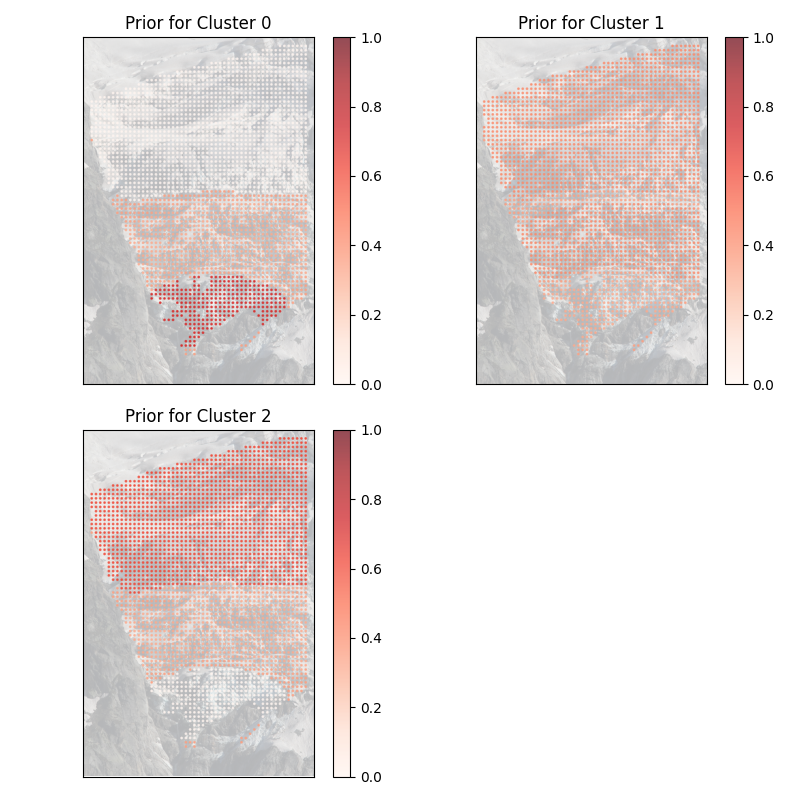

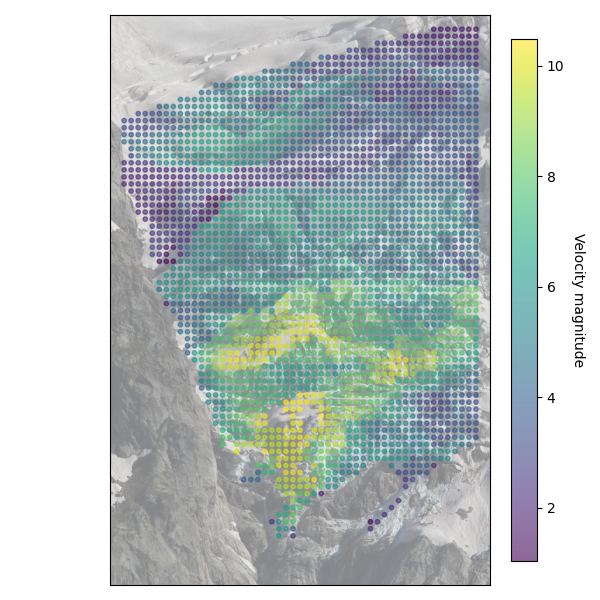

In [4]:
sigma_values = [2, 3]  # Different Gaussian smoothing scales

# Assign spatial priors
prior_probs = assign_spatial_priors(
    x=df["x"].to_numpy(),
    y=df["y"].to_numpy(),
    polygons=sectors,
    prior_probs=PRIOR_PROBABILITY,
    # method="exponential",
    # method_kws={"decay_rate": 0.001},
)

fig, axes = plot_spatial_priors(df, prior_probs, img=img)
fig.savefig(
    output_dir / f"{base_name}_spatial_priors.jpg",
    dpi=150,
    bbox_inches="tight",
)

# Plot velocity field
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_velocity_magnitude(
    df["x"].to_numpy(),
    df["y"].to_numpy(),
    df["V"].to_numpy(),
    img=img,
    ax=ax,
)
fig.savefig(
    output_dir / f"{base_name}_velocity_field.jpg",
    dpi=150,
    bbox_inches="tight",
)

In [8]:
def preprocess_velocity_features(
    velocities,
    velocity_transform="power",
    velocity_params=None,
    output_dir=None,
    base_name=None,
):
    """
    Preprocess velocity features with various transformation options.

    Parameters:
    -----------
    velocities : numpy.ndarray
        1D array of velocity magnitudes
    velocity_transform : str, default="power"
        Type of velocity transformation: "power", "exponential", "threshold", "sigmoid", or "none"
    velocity_params : dict, optional
        Parameters for velocity transformation. Defaults depend on transform type:
        - "power": {"exponent": 2}
        - "exponential": {"scale": 0.2}
        - "threshold": {"threshold_percentile": 50, "enhancement": 3.0}
        - "sigmoid": {"midpoint_percentile": 70, "steepness": 2.0}
        - "none": {}
    output_dir : Path, optional
        Directory to save scaler (if provided)
    base_name : str, optional
        Base name for scaler file (if provided)

    Returns:
    --------
    tuple : (velocities_transformed, scaler, transform_info)
        - velocities_transformed: numpy.ndarray of transformed velocities
        - scaler: Fitted StandardScaler
        - transform_info: Dictionary with transformation metadata
    """
    # Ensure input is numpy array
    velocities = np.asarray(velocities)

    # Set default velocity transformation parameters
    if velocity_params is None:
        velocity_params = {
            "power": {"exponent": 2},
            "exponential": {"scale": 0.2},
            "threshold": {"threshold_percentile": 50, "enhancement": 3.0},
            "sigmoid": {"midpoint_percentile": 70, "steepness": 2.0},
            "none": {},
        }.get(velocity_transform, {})

    # Apply velocity transformation
    if velocity_transform == "power":
        exponent = velocity_params.get("exponent", 2)
        velocities_transformed = velocities**exponent
        transform_info = {"type": "power", "exponent": exponent}

    elif velocity_transform == "exponential":
        scale = velocity_params.get("scale", 0.2)
        velocities_transformed = np.exp(scale * velocities) - 1
        transform_info = {"type": "exponential", "scale": scale}

    elif velocity_transform == "threshold":
        threshold_percentile = velocity_params.get("threshold_percentile", 50)
        enhancement = velocity_params.get("enhancement", 3.0)
        threshold = np.percentile(velocities, threshold_percentile)
        velocities_transformed = np.where(
            velocities > threshold,
            velocities * enhancement,
            velocities,
        )
        transform_info = {
            "type": "threshold",
            "threshold": threshold,
            "enhancement": enhancement,
        }

    elif velocity_transform == "sigmoid":
        midpoint_percentile = velocity_params.get("midpoint_percentile", 70)
        steepness = velocity_params.get("steepness", 2.0)
        midpoint = np.percentile(velocities, midpoint_percentile)
        velocities_transformed = 1 / (1 + np.exp(-steepness * (velocities - midpoint)))
        transform_info = {
            "type": "sigmoid",
            "midpoint": midpoint,
            "steepness": steepness,
        }

    else:  # "none" or any other value
        velocities_transformed = velocities.copy()
        transform_info = {"type": "none"}

    # Fit scaler on transformed data (reshape for sklearn)
    scaler = StandardScaler()
    scaler.fit(velocities_transformed.reshape(-1, 1))

    # Save scaler if output directory provided
    if output_dir is not None and base_name is not None:
        joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")

    logger.info(
        f"Applied {velocity_transform} transformation with params: {velocity_params}"
    )
    logger.info(f"Feature shape: {velocities_transformed.shape}")

    return velocities_transformed, scaler, transform_info

In [9]:
def run_mcmc_clustering(
    df_input,
    prior_probs,
    sectors,
    output_dir,
    base_name,
    img=None,
    transform_velocity="none",
    transform_params=None,
    mu_params=None,
    sigma_params=None,
    feature_weights=None,
    sample_args=None,
    variables_names=None,
    random_seed=8927,
):
    """
    Run MCMC-based clustering on velocity data with flexible velocity transformations.

    Parameters:
    -----------
    df_input : pandas.DataFrame
        Input dataframe with 'x', 'y', 'V' columns
    transform_velocity : str, default="none"
        Type of velocity transformation: "power", "exponential", "threshold", "sigmoid", or "none"
    transform_params : dict, optional
        Parameters for velocity transformation (see preprocess_velocity_features for details)
    """
    logger.info(f"Running MCMC clustering for {base_name}...")

    # Make a copy to avoid modifying the input
    # df_run = df_input.copy()

    # Default parameters if not provided
    if mu_params is None:
        mu_params = {"mu": 0, "sigma": 1}
    if sigma_params is None:
        sigma_params = {"sigma": 1}
    if sample_args is None:
        sample_args = dict(
            target_accept=0.95,
            draws=2000,
            tune=1000,
            chains=4,
            cores=4,
            random_seed=random_seed,
        )
    if variables_names is None:
        variables_names = ["V"]
    if feature_weights is None:
        feature_weights = [1.0, 0.3] if len(variables_names) > 1 else None

    # Extract velocity array from dataframe
    velocities = df_input["V"].to_numpy()

    # Preprocess velocity features to enhance high velocities
    if transform_params != "none":
        velocities, scaler, transform_info = preprocess_velocity_features(
            velocities=velocities,
            velocity_transform=transform_velocity,
            velocity_params=transform_params,
            output_dir=output_dir,
            base_name=base_name,
        )
    else:
        scaler = StandardScaler()
        scaler.fit(velocities.reshape(-1, 1))
        joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
        transform_info = {"type": "none"}
        logger.info("No velocity transformation applied.")

    # Scale data for model input
    data_array_scaled = scaler.transform(velocities.reshape(-1, 1))

    logger.info(f"Running MCMC clustering for {base_name}...")

    # Build model
    model = build_marginalized_mixture_model(
        data_array_scaled,
        prior_probs,
        sectors,
        mu_params=mu_params,
        sigma_params=sigma_params,
        feature_weights=feature_weights,
    )

    # Sample model
    idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)
    if not convergence_flag:
        idata_summary = az.summary(idata, var_names=["mu", "sigma"])
        logger.info(f"MCMC did not converge. Summary:\n{idata_summary}")

    # Compute cluster assignments
    # if transform_params != "none":
    #     posterior_probs, cluster_pred, uncertainty = (
    #         compute_posterior_assignments_with_scaling(
    #             idata,
    #             scaler,
    #             transform_info,
    #             original_velocities=df_input["V"].to_numpy(),
    #             n_posterior_samples=200,
    #         )
    #     )
    # else:
    posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
        idata, n_posterior_samples=200
    )

    # Generate plots
    fig = plot_velocity_clustering(
        df_features=df_input,  # Use original data for plotting
        img=img,
        idata=idata,
        cluster_pred=cluster_pred,
        posterior_probs=posterior_probs,
        scaler=scaler,
    )
    fig.savefig(
        output_dir / f"{base_name}_results.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

    # Trace plots
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    az.plot_trace(
        idata, var_names=["mu", "sigma"], axes=axes, compact=True, legend=True
    )
    fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)
    plt.close(fig)

    # Forest plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    az.plot_forest(idata, var_names=["mu", "sigma"], combined=True, ess=True, ax=axes)
    fig.savefig(output_dir / f"{base_name}_forest_plot.png", dpi=150)
    plt.close(fig)

    # Collect and save metadata
    metadata = collect_run_metadata(
        idata=idata,
        convergence_flag=convergence_flag,
        data_array_scaled=data_array_scaled,
        variables_names=variables_names,
        sectors=sectors,
        prior_probs=prior_probs,
        sample_args=sample_args,
        frame=locals(),
    )
    save_run_metadata(output_dir, base_name, metadata)

    # Return results dictionary
    result = {
        "metadata": metadata,
        "idata": idata,
        "scaler": scaler,
        "convergence_flag": convergence_flag,
        "posterior_probs": posterior_probs,
        "cluster_pred": cluster_pred,
        "uncertainty": uncertainty,
    }

    plt.close("all")
    return result

In [ ]:
# Define sigma values for Gaussian smoothing
sigma_values = [1, 2, 3]

# Loop through smoothing scales
results = []
for sigma in sigma_values:
    logger.info(f"Processing with Gaussian smoothing sigma={sigma}...")

    # Create scale-specific base name
    scale_base_name = f"{reference_start_date}_{reference_end_date}_sigma{sigma}"

    # Apply Gaussian smoothing if needed
    df_run = apply_2d_gaussian_filter(df, sigma=sigma) if sigma > 0 else df.copy()

    # Adjust model parameters based on scale
    mu_params = {"mu": 0, "sigma": 1 if sigma <= 2 else 0.5}
    sigma_params = {"sigma": 1 if sigma <= 2 else 0.5}

    # Run MCMC clustering with the smoothed data
    result = run_mcmc_clustering(
        df_input=df_run,
        prior_probs=prior_probs,
        sectors=sectors,
        output_dir=output_dir,
        base_name=scale_base_name,
        img=img,
        transform_velocity="exponential",
        transform_params={"scale": 0.1},
        mu_params=mu_params,
        sigma_params=sigma_params,
        random_seed=RANDOM_SEED,
    )

    # Add scale information to result
    result["sigma"] = sigma

    # Append to results list
    results.append(result)

# Save all results to a single joblib file
# joblib.dump(
#     results,
#     output_dir
#     / f"{reference_start_date}_{reference_end_date}_all_results_multiscale.joblib",
# )

2025-09-24 17:50:35 | [INFO    ] Processing with Gaussian smoothing sigma=1...
2025-09-24 17:50:35 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=1
2025-09-24 17:50:35 | [INFO    ] Estimated grid spacing: 64.00
2025-09-24 17:50:35 | [INFO    ] Created 2D grid: (73, 51), 2619 valid points
2025-09-24 17:50:35 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
2025-09-24 17:50:35 | [INFO    ] Running MCMC clustering for 2024-06-29_2024-06-29_sigma1...
2025-09-24 17:50:35 | [INFO    ] Applied exponential transformation with params: {'scale': 0.1}
2025-09-24 17:50:35 | [INFO    ] Feature shape: (2619,)
2025-09-24 17:50:35 | [INFO    ] Running MCMC clustering for 2024-06-29_2024-06-29_sigma1...
2025-09-24 17:50:35 | [INFO    ] Marginalized mixture model (un-sampled) created.
2025-09-24 17:50:35 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, 

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
2025-09-24 17:51:09 | [INFO    ] Sampling completed.
/home/francesco/ppcx/ppcx-domains/src/ppcluster/mcmc.py:716: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(
2025-09-24 17:51:19 | [WARNING ] This function is temporary and it will be replaced by a more structured configuration system.
2025-09-24 17:51:19 | [INFO    ] Experiment metadata saved to output/PPCX_Tele_2024-06-29_mcmc_multiscale/2024-06-29_2024-06-29_sigma1_metadata.json
2025-09-24 17:51:19 | [INFO    ] Processing with Gaussian smoothing sigma=2...
2025-09-24 17:51:19 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=2
2025

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
2025-09-24 17:51:53 | [INFO    ] Sampling completed.
/home/francesco/ppcx/ppcx-domains/src/ppcluster/mcmc.py:716: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(
2025-09-24 17:52:02 | [WARNING ] This function is temporary and it will be replaced by a more structured configuration system.
2025-09-24 17:52:03 | [INFO    ] Experiment metadata saved to output/PPCX_Tele_2024-06-29_mcmc_multiscale/2024-06-29_2024-06-29_sigma2_metadata.json
2025-09-24 17:52:03 | [INFO    ] Processing with Gaussian smoothing sigma=3...
2025-09-24 17:52:03 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=3
2025

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
2025-09-24 17:52:36 | [INFO    ] Sampling completed.
2025-09-24 17:52:37 | [WARNING ] MCMC chains did not fully converge by r_hat/ess criteria.
2025-09-24 17:52:40 | [INFO    ] MCMC did not converge. Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     1.281  0.040   1.202    1.342      0.017    0.008       7.0   
mu[1, 0]    -0.377  0.361  -1.018   -0.140      0.180    0.104       7.0   
mu[2, 0]    -0.765  0.297  -0.967   -0.234      0.148    0.085       7.0   
sigma[0, 0]  0.510  0.029   0.466    0.56

In [11]:
# Read the results again
# results = joblib.load(
#     output_dir
#     / f"{reference_start_date}_{reference_end_date}_all_results_multiscale.joblib",
# )

2025-09-24 18:32:47 | [INFO    ] Overall stability score: 0.83
2025-09-24 18:32:47 | [INFO    ] Using 3/3 scales: sigma=[1 2 3]
2025-09-24 18:32:51 | [WARNING ] Points are not on a regular grid. Interpolation may be needed.
2025-09-24 18:32:51 | [INFO    ] Estimated grid spacing: 64.00


[]

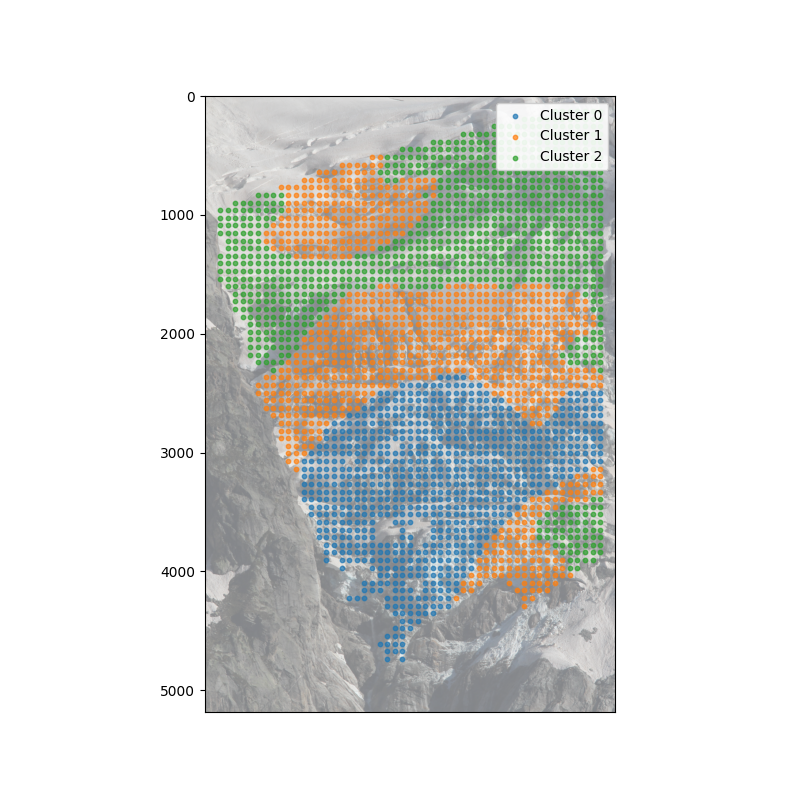

In [ ]:
from ppcx_postproc_func import (
    create_2d_grid,
    map_grid_to_points,
    remove_small_grid_components,
)


def aggregate_multiscale_clustering(
    results, similarity_threshold=0.6, overall_threshold=0.7, fig_path=None
):
    """
    Aggregate clustering results across scales, filtering unstable scales.

    Parameters:
    -----------
    results : list of dict
        Results from different scale clustering runs
    similarity_threshold : float
        Minimum mean similarity for a scale to be included
    overall_threshold : float
        Minimum overall similarity across scales to accept results

    Returns:
    --------
    combined_cluster_pred : ndarray
        Aggregated cluster assignments
    stability_score : float
        Measure of overall stability (0-1)
    """

    # Extract all cluster predictions
    all_cluster_preds = np.array([res["cluster_pred"] for res in results])
    n_scales = len(all_cluster_preds)
    sigma_values = [res["sigma"] for res in results]

    # Calculate pairwise similarities
    similarity_matrix = np.zeros((n_scales, n_scales))
    np.fill_diagonal(similarity_matrix, 1.0)
    for i, j in combinations(range(n_scales), 2):
        sim = adjusted_rand_score(all_cluster_preds[i], all_cluster_preds[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

    # Plot similarity heatmap
    if fig_path is not None:
        fig_path = Path(fig_path)
        fig_path.parent.mkdir(parents=True, exist_ok=True)
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(
            similarity_matrix,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            xticklabels=sigma_values,
            yticklabels=sigma_values,
        )
        plt.title("Adjusted Rand Index Between Scales")
        plt.xlabel("Sigma")
        plt.ylabel("Sigma")
        plt.tight_layout()
        fig.savefig(fig_path, dpi=100, bbox_inches="tight")
        plt.close(fig)

    # Calculate mean similarity for each scale (exclude self-similarity)
    mean_similarities = (similarity_matrix.sum(axis=1) - 1) / (n_scales - 1)

    # Filter scales with low similarity
    valid_scales = mean_similarities >= similarity_threshold
    if not np.any(valid_scales):
        raise ValueError(
            f"No scales meet the similarity threshold of {similarity_threshold}. "
            f"Mean similarities: {mean_similarities}"
        )

    # Get overall stability score (mean of valid scale similarities)
    valid_sim_matrix = similarity_matrix[np.ix_(valid_scales, valid_scales)]
    stability_score = valid_sim_matrix.mean()
    logger.info(f"Overall stability score: {stability_score:.2f}")

    # Check if overall stability is too low
    if stability_score < overall_threshold:
        raise ValueError(
            f"Overall clustering stability ({stability_score:.2f}) is below threshold "
            f"({overall_threshold}). Results are too unstable across scales."
        )

    # Get valid cluster predictions and compute mode
    valid_preds = all_cluster_preds[valid_scales]
    logger.info(
        f"Using {sum(valid_scales)}/{n_scales} scales: sigma={np.array(sigma_values)[valid_scales]}"
    )

    # Compute mode (most common label at each point)
    combined_cluster_pred, _ = mode(valid_preds, axis=0)
    combined_cluster_pred = combined_cluster_pred.flatten()

    return combined_cluster_pred, similarity_matrix, stability_score, valid_scales


# If a multi-scale approach was used, aggregate the results.
if len(sigma_values) > 1:
    cluster_pred, similarity_matrix, stability_score, valid_scales = (
        aggregate_multiscale_clustering(
            results,
            similarity_threshold=0.7,
            overall_threshold=0.8,
            fig_path=output_dir
            / f"{reference_start_date}_{reference_end_date}_similarity_heatmap.jpg",
        )
    )

    # Create a "prior class" assignment based on the sector with highest probability
    sector_names = list(PRIOR_PROBABILITY.keys())
    sector_assignments = np.zeros_like(cluster_pred)
    for i, point_probs in enumerate(prior_probs):
        sector_assignments[i] = np.argmax(point_probs)

    # Compute similarity metrics
    ari = adjusted_rand_score(sector_assignments, cluster_pred)
    ami = adjusted_mutual_info_score(sector_assignments, cluster_pred)

    # Plot final combined clustering
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    if img is not None:
        ax.imshow(img, alpha=0.5, cmap="gray")

    colormap = plt.get_cmap("tab10")
    for i, label in enumerate(np.unique(cluster_pred)):
        mask = cluster_pred == label
        ax.scatter(
            df["x"][mask],
            df["y"][mask],
            color=colormap(i),
            label=f"Cluster {label}",
            s=10,
            alpha=0.7,
        )
    ax.legend(loc="upper right", framealpha=0.9, fontsize=10)
    ax.set_aspect("equal")
    ax.set_title(
        f"Combined Clustering (across-scale stability: {stability_score:.2f})\n"
        f"Prior Agreement: AMI={ami:.2f}"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(
        output_dir
        / f"{reference_start_date}_{reference_end_date}_combined_clustering.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

    cluster_aggregation_outs = {
        "cluster_pred": cluster_pred,
        "stability_score": stability_score,
        "valid_scales": valid_scales,
        "sigma_values": sigma_values,
    }
    joblib.dump(
        cluster_aggregation_outs,
        output_dir
        / f"{reference_start_date}_{reference_end_date}_combined_clustering.joblib",
    )

else:
    # Otherwise extract the single result

    cluster_pred = results[0]["cluster_pred"]

# Do some post-processing on the clustering results
X, Y, label_grid = create_2d_grid(
    x=df["x"].to_numpy(), y=df["y"].to_numpy(), labels=cluster_pred, grid_spacing=None
)

min_size = 20  # Minimum size of connected components to keep
connectivity = 8  # 4 or 8 for pixel connectivity
label_grid = remove_small_grid_components(
    label_grid, min_size=min_size, connectivity=connectivity
)

point_labels_cleaned, x, y = map_grid_to_points(
    X,
    Y,
    label_grid,
    x_points=df["x"].to_numpy(),
    y_points=df["y"].to_numpy(),
    keep_nan=False,
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img, alpha=0.5, cmap="gray")
colormap = plt.get_cmap("tab10")
for i, label in enumerate(np.unique(point_labels_cleaned)):
    mask = point_labels_cleaned == label
    ax.scatter(
        x[mask],
        y[mask],
        color=colormap(i),
        label=f"Cluster {label}",
        s=10,
        alpha=0.7,
    )
ax.legend(loc="upper right", framealpha=0.9, fontsize=10)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

In [96]:
from scipy import ndimage
from scipy.stats import binned_statistic

vertical_bins = 50
min_points_per_bin = 10
gradient_threshold = 0.4
smoothing_sigma = 1.0

# Use the smoothed dataframe finding morpho-kinematic boundaries
df_smooth = apply_2d_gaussian_filter(df, sigma=2)
x = df_smooth["x"].to_numpy()
y = df_smooth["y"].to_numpy()
v = df_smooth["V"].to_numpy()

# Compute bin statistics
y_min, y_max = y.min(), y.max()
bin_edges = np.linspace(y_min, y_max, vertical_bins + 1)
count_binned = binned_statistic(y, np.ones_like(y), statistic="count", bins=bin_edges)
mean_binned = binned_statistic(y, v, statistic="mean", bins=bin_edges)
points_per_bin = count_binned.statistic.astype(int)
valid_bins = points_per_bin >= min_points_per_bin
mean_velocities = np.where(valid_bins, mean_binned.statistic, 0.0)

# Apply smoothing to velocity profile for valid bins only
if np.any(valid_bins) and np.sum(valid_bins) > 3:
    # Create continuous array for smoothing
    smoothed_velocities = mean_velocities.copy()
    valid_indices = np.where(valid_bins)[0]

    # Fill invalid bins with nearest neighbor values for smoothing
    for i in range(vertical_bins):
        if not valid_bins[i] and len(valid_indices) > 0:
            nearest_idx = valid_indices[np.argmin(np.abs(valid_indices - i))]
            smoothed_velocities[i] = smoothed_velocities[nearest_idx]

    # Apply Gaussian smoothing
    smoothed_velocities = ndimage.gaussian_filter1d(
        smoothed_velocities, sigma=smoothing_sigma
    )
else:
    smoothed_velocities = mean_velocities.copy()

# Calculate velocity gradient (derivative)
bin_width = np.mean(mean_binned.bin_edges[1:] - mean_binned.bin_edges[:-1])
vel_gradient = np.gradient(smoothed_velocities) / bin_width

# Identify significant velocity transitions using gradient threshold
# Focusing on negative gradients (velocity decreases moving upward)
gradient_threshold_value = gradient_threshold * np.min(vel_gradient)
transition_indices = []
transition_strengths = []

for i in range(1, len(vel_gradient) - 1):
    # Skip bins with too few points
    if not valid_bins[i]:
        continue

    # Check for significant negative gradient (velocity decrease)
    if vel_gradient[i] < gradient_threshold_value:
        # Verify this is a peak in the gradient (local minimum)
        if (
            vel_gradient[i] < vel_gradient[i - 1]
            and vel_gradient[i] < vel_gradient[i + 1]
        ):
            transition_indices.append(i)
            transition_strengths.append(abs(vel_gradient[i]))

# Convert transition indices to y-coordinates
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
boundaries = [bin_centers[i] for i in transition_indices]

# Sort boundaries by y-coordinate (bottom to top)
boundaries = sorted(boundaries)

# If no transitions found, raise a warning
if len(boundaries) == 0:
    logger.warning("No morpho boundaries detected.")
elif len(boundaries) > 1:
    domain_labels = np.zeros_like(cluster_pred, dtype=int)

    # Sort boundaries from bottom to top (highest y to lowest y)
    sorted_boundaries = sorted(boundaries, reverse=True)

    # In image coordinates, higher y values are at the bottom
    # Domain A is at the bottom (highest y values)
    domain_labels[(y >= sorted_boundaries[0])] = 0  # Domain A (bottom)

    # Middle domains if multiple boundaries
    for i in range(len(sorted_boundaries) - 1):
        domain_labels[(y < sorted_boundaries[i]) & (y >= sorted_boundaries[i + 1])] = (
            i + 1
        )

    # Upper domain (top of image, lowest y values)
    domain_labels[(y < sorted_boundaries[-1])] = len(sorted_boundaries)

    # Assign a letter in morpho_domains dictionary for each domain
    domain_labels_str = ["A", "B", "C", "D"]
    morpho_domains = {}

    for i in range(len(sorted_boundaries) + 1):
        morpho_domains[domain_labels_str[i]] = i

2025-09-24 18:38:41 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=2


2025-09-24 18:38:41 | [INFO    ] Estimated grid spacing: 64.00
2025-09-24 18:38:41 | [INFO    ] Created 2D grid: (73, 51), 2619 valid points
2025-09-24 18:38:41 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0


/tmp/ipykernel_2986190/3174350846.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


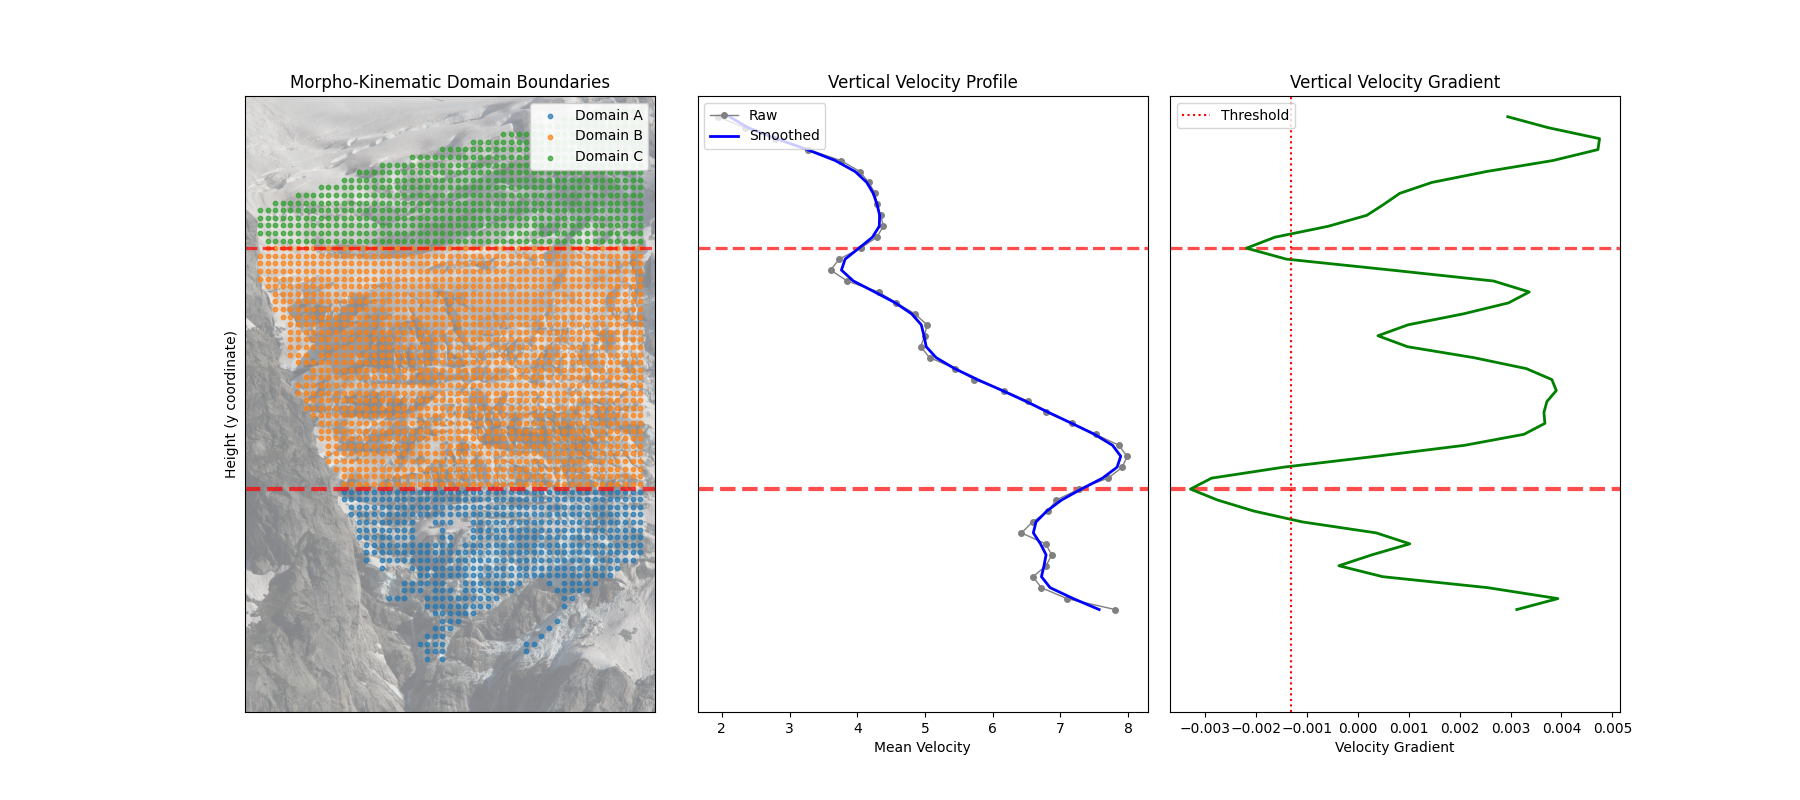

In [ ]:
colormap = plt.get_cmap("tab10")

# Create figure with shared y-axis
fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(1, 3, wspace=0.05)

# Create axes with shared y-axis
ax1 = fig.add_subplot(gs[0, 0])  # Domain visualization
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)  # Velocity profile
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)  # Velocity gradient

# 1. Domains visualization
# Plot domains in order from bottom to top
ax1.imshow(img, alpha=0.5, cmap="gray")
for i, (label, domain_id) in enumerate(morpho_domains.items()):
    mask = domain_labels == domain_id
    ax1.scatter(
        x[mask],
        y[mask],
        color=colormap(i),
        label=f"Domain {label}",
        s=10,
        alpha=0.7,
    )

# Draw horizontal boundary lines
for i, bound in enumerate(boundaries):
    strength = (
        transition_strengths[i] / max(transition_strengths)
        if transition_strengths
        else 1.0
    )
    for ax in [ax1, ax2, ax3]:
        ax.axhline(
            y=bound,
            color="red",
            linestyle="--",
            linewidth=1 + 2 * strength,
            alpha=0.7,
        )

# 2. Velocity profile with transitions
ax2.plot(
    mean_velocities[valid_bins],
    bin_centers[valid_bins],
    "o-",
    color="gray",
    markersize=4,
    linewidth=1,
    label="Raw",
)
ax2.plot(
    smoothed_velocities[valid_bins],
    bin_centers[valid_bins],
    "b-",
    linewidth=2,
    label="Smoothed",
)

# 3. Velocity gradient
ax3.plot(vel_gradient[valid_bins], bin_centers[valid_bins], "g-", linewidth=2)
ax3.axvline(x=gradient_threshold_value, color="r", linestyle=":", label="Threshold")

# Set titles and labels
ax1.set_title("Morpho-Kinematic Domain Boundaries")
ax2.set_title("Vertical Velocity Profile")
ax3.set_title("Vertical Velocity Gradient")

ax1.set_xlabel("")
ax2.set_xlabel("Mean Velocity")
ax3.set_xlabel("Velocity Gradient")

# Only show y-axis label on first subplot
ax1.set_ylabel("Height (y coordinate)")

# Remove tick labels on shared axis
ax2.tick_params(axis="y", labelright=False, labelleft=False)
ax3.tick_params(axis="y", labelright=False, labelleft=False)

# Keep x-ticks only for the profiles
ax1.set_xticks([])
ax1.set_yticks([])

# Add legends
ax1.legend(loc="upper right", frameon=True, framealpha=0.9)
ax2.legend(loc="upper left")
ax3.legend(loc="upper left")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.12)


In [ ]:
def integrate_morpho_kinematics(
    df,
    cluster_pred,
    domain_labels,
    boundaries,
    output_dir=None,
    base_name=None,
    img=None,
    min_percentage=15,
):
    """
    Integrate morphological boundaries with kinematic clusters.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with x, y coordinates
    cluster_pred : numpy.ndarray
        Kinematic cluster labels for each point
    domain_labels : numpy.ndarray
        Morphological domain labels (A, B, C) based on velocity transitions
    boundaries : list
        Y-coordinates of morphological boundaries
    min_percentage : int, default=15
        Minimum percentage for a cluster to be considered significant in a domain

    Returns:
    --------
    dict
        Dictionary with integrated domain information
    """
    # Ensure all arrays have the same length
    if len(domain_labels) != len(cluster_pred):
        logger.warning(
            f"Shape mismatch: domain_labels={len(domain_labels)}, cluster_pred={len(cluster_pred)}"
        )
        # Use the common indices from df to ensure alignment
        common_length = min(len(df), len(domain_labels), len(cluster_pred))
        domain_labels = domain_labels[:common_length]
        cluster_pred = cluster_pred[:common_length]

    # Get arrays for coordinates and domain info
    x = df["x"].to_numpy()[: len(domain_labels)]  # Ensure same length as domain_labels
    y = df["y"].to_numpy()[: len(domain_labels)]  # Ensure same length as domain_labels

    # Get unique domains and clusters
    unique_domains = np.unique(domain_labels)
    unique_clusters = np.unique(cluster_pred)

    # Create dictionary to store integrated info
    domain_info = {}
    for domain in unique_domains:
        domain_mask = domain_labels == domain
        domain_points = np.sum(domain_mask)

        if domain_points == 0:
            logger.warning(f"Domain {domain} has 0 points, skipping")
            continue

        # Count clusters in this domain
        cluster_counts = {}
        for cluster in unique_clusters:
            cluster_mask = cluster_pred == cluster
            overlap = np.sum(domain_mask & cluster_mask)
            percentage = 100 * overlap / domain_points
            cluster_counts[cluster] = {
                "count": int(overlap),
                "percentage": float(percentage),
            }

        # Sort clusters by percentage
        sorted_clusters = sorted(
            cluster_counts.items(), key=lambda x: x[1]["percentage"], reverse=True
        )

        if not sorted_clusters:
            logger.warning(f"No clusters found in domain {domain}, skipping")
            continue

        # Get primary and secondary clusters (if they meet threshold)
        primary_cluster = sorted_clusters[0][0]
        primary_percentage = sorted_clusters[0][1]["percentage"]

        secondary_cluster = None
        secondary_percentage = 0
        if (
            len(sorted_clusters) > 1
            and sorted_clusters[1][1]["percentage"] >= min_percentage
        ):
            secondary_cluster = sorted_clusters[1][0]
            secondary_percentage = sorted_clusters[1][1]["percentage"]

        # Store domain info
        domain_name = ["A", "B", "C", "D"][domain] if domain < 4 else f"Domain {domain}"
        domain_info[domain_name] = {
            "domain_id": int(domain),
            "primary_cluster": int(primary_cluster),
            "primary_percentage": float(primary_percentage),
            "secondary_cluster": int(secondary_cluster)
            if secondary_cluster is not None
            else None,
            "secondary_percentage": float(secondary_percentage),
            "cluster_distribution": {int(k): v for k, v in cluster_counts.items()},
        }

    # Create morpho-kinematic labels
    morpho_kinematic_labels = np.zeros_like(domain_labels, dtype=int)
    for domain in unique_domains:
        domain_name = ["A", "B", "C", "D"][domain] if domain < 4 else f"Domain {domain}"
        if domain_name not in domain_info:
            continue  # Skip if we didn't find clusters in this domain

        domain_mask = domain_labels == domain
        primary_cluster = domain_info[domain_name]["primary_cluster"]

        # Create combined label (domain*10 + cluster)
        # This gives us labels like: 01, 02, 11, 12, 21, etc.
        morpho_kinematic_labels[domain_mask] = domain * 10 + primary_cluster

    # Plot integrated domains
    if output_dir is not None and base_name is not None:
        fig, ax = plt.subplots(figsize=(10, 10))

        if img is not None:
            ax.imshow(img, alpha=0.5, cmap="gray")

        # Create colormap with distinct colors for each morpho-kinematic unit
        unique_mk_labels = np.unique(morpho_kinematic_labels)
        mk_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_mk_labels)))

        # Plot each morpho-kinematic unit
        for i, mk_label in enumerate(unique_mk_labels):
            mask = morpho_kinematic_labels == mk_label
            domain_id = mk_label // 10
            cluster_id = mk_label % 10
            domain_name = (
                ["A", "B", "C", "D"][domain_id] if domain_id < 4 else f"D{domain_id}"
            )

            ax.scatter(
                x[mask],
                y[mask],
                color=mk_colors[i],
                label=f"Domain {domain_name}-K{cluster_id}",
                s=10,
                alpha=0.7,
            )

        # Draw boundaries
        for bound in boundaries:
            ax.axhline(y=bound, color="red", linestyle="--", alpha=0.7, linewidth=2)

        ax.legend(loc="upper right", frameon=True, framealpha=0.9)
        ax.set_title("Integrated Morpho-Kinematic Domains")
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])

        plt.savefig(
            output_dir / f"{base_name}_morpho_kinematic_domains.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close(fig)

        # Create table showing domain characteristics
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis("off")
        table_data = []
        table_columns = [
            "Domain",
            "Primary Cluster",
            "Primary %",
            "Secondary Cluster",
            "Secondary %",
        ]

        for domain_name, info in domain_info.items():
            secondary = (
                f"{info['secondary_cluster']} ({info['secondary_percentage']:.1f}%)"
                if info["secondary_cluster"] is not None
                else "None"
            )
            table_data.append(
                [
                    domain_name,
                    f"{info['primary_cluster']}",
                    f"{info['primary_percentage']:.1f}%",
                    secondary.split()[0] if secondary != "None" else "None",
                    f"{info['secondary_percentage']:.1f}%"
                    if info["secondary_cluster"] is not None
                    else "0%",
                ]
            )

        table = ax.table(
            cellText=table_data, colLabels=table_columns, loc="center", cellLoc="center"
        )
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 2)

        plt.savefig(
            output_dir / f"{base_name}_domain_statistics.png",
            dpi=200,
            bbox_inches="tight",
        )
        plt.close(fig)

    return {
        "domain_info": domain_info,
        "morpho_kinematic_labels": morpho_kinematic_labels,
        "boundaries": boundaries,
    }


In [105]:
# Check lengths first
print(f"df length: {len(df)}")
print(f"point_labels_cleaned length: {len(point_labels_cleaned)}")
print(f"domain_labels length: {len(domain_labels)}")

morpho_kinematic_results = integrate_morpho_kinematics(
    df=df,
    cluster_pred=point_labels_cleaned,  # Using the cleaned cluster labels
    domain_labels=domain_labels,
    boundaries=boundaries,
    output_dir=output_dir,
    base_name=f"{reference_start_date}_{reference_end_date}",
    img=img,
    min_percentage=15,  # Minimum percentage to consider a secondary cluster
)


df length: 2619
point_labels_cleaned length: 2613
domain_labels length: 2619


ValueError: operands could not be broadcast together with shapes (2619,) (2613,) 